In [67]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import os

In [68]:
full_df = pd.read_csv("series_data.csv", low_memory=False)
image_output_directory = "./images"
table_output_directory = "./tables"

os.makedirs(image_output_directory, exist_ok=True)
os.makedirs(table_output_directory, exist_ok=True)

full_df.head()

,step,value,timestamp,namespace,metric,run_id,tags,alpha,control_on_realized,lr,lr_method,method,num_classes,selectively_backpropagate,val_alpha
0,594.0,1.0,2024-08-10 19:58:30.322,training,Train Dataset Size,CITL-111,"['efficientnet-b0', 'complete', 'Method', 'Cit...",0.1,False,0.0005,plateau,score,20,True,0.1
1,1189.0,1.0,2024-08-10 20:01:40.743,training,Train Dataset Size,CITL-111,"['efficientnet-b0', 'complete', 'Method', 'Cit...",0.1,False,0.0005,plateau,score,20,True,0.1
2,1784.0,1.0,2024-08-10 20:04:51.586,training,Train Dataset Size,CITL-111,"['efficientnet-b0', 'complete', 'Method', 'Cit...",0.1,False,0.0005,plateau,score,20,True,0.1
3,2379.0,1.0,2024-08-10 20:08:02.505,training,Train Dataset Size,CITL-111,"['efficientnet-b0', 'complete', 'Method', 'Cit...",0.1,False,0.0005,plateau,score,20,True,0.1
4,2974.0,1.0,2024-08-10 20:11:12.949,training,Train Dataset Size,CITL-111,"['efficientnet-b0', 'complete', 'Method', 'Cit...",0.1,False,0.0005,plateau,score,20,True,0.1


In [69]:
def get_dataset(tags):
    if "DFire" in tags:
        return "DFire"
    elif "CityscapesFine" in tags:
        return "Cityscapes"
    elif "CIFAR10" in tags:
        return "CIFAR10"
    else:
        raise ValueError(f"Unknown dataset: {tags}")

In [70]:
def get_purpose(tags):
    if "Method" in tags:
        return "Method"
    elif "Baseline" in tags:
        return "Baseline"
    elif "Standard" in tags:
        return "Standard"
    else:
        raise ValueError(f"Unknown method: {tags}")

In [71]:
full_df["dataset"] = full_df["tags"].apply(lambda x: get_dataset(x))
full_df["timestamp"] = pd.to_datetime(full_df["timestamp"])
full_df["purpose"] = full_df["tags"].apply(lambda x: get_purpose(x))

standard_trains = full_df[full_df["method"].isna()]
citl_trains = full_df[~full_df["method"].isna()]
assert len(standard_trains) + len(citl_trains) == len(full_df)

full_df.head()

,step,value,timestamp,namespace,metric,run_id,tags,alpha,control_on_realized,lr,lr_method,method,num_classes,selectively_backpropagate,val_alpha,dataset,purpose
0,594.0,1.0,2024-08-10 19:58:30.322,training,Train Dataset Size,CITL-111,"['efficientnet-b0', 'complete', 'Method', 'Cit...",0.1,False,0.0005,plateau,score,20,True,0.1,Cityscapes,Method
1,1189.0,1.0,2024-08-10 20:01:40.743,training,Train Dataset Size,CITL-111,"['efficientnet-b0', 'complete', 'Method', 'Cit...",0.1,False,0.0005,plateau,score,20,True,0.1,Cityscapes,Method
2,1784.0,1.0,2024-08-10 20:04:51.586,training,Train Dataset Size,CITL-111,"['efficientnet-b0', 'complete', 'Method', 'Cit...",0.1,False,0.0005,plateau,score,20,True,0.1,Cityscapes,Method
3,2379.0,1.0,2024-08-10 20:08:02.505,training,Train Dataset Size,CITL-111,"['efficientnet-b0', 'complete', 'Method', 'Cit...",0.1,False,0.0005,plateau,score,20,True,0.1,Cityscapes,Method
4,2974.0,1.0,2024-08-10 20:11:12.949,training,Train Dataset Size,CITL-111,"['efficientnet-b0', 'complete', 'Method', 'Cit...",0.1,False,0.0005,plateau,score,20,True,0.1,Cityscapes,Method


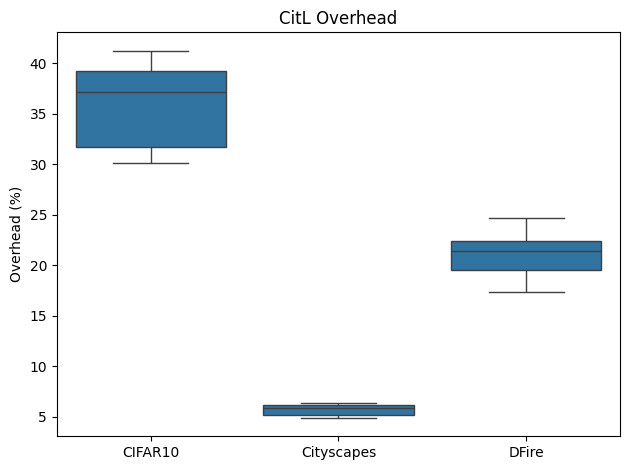

In [197]:
### OVERHEAD
standard_times = standard_trains.groupby(by=["dataset"]).agg({"timestamp": ['max', 'min'], "step": "max"})
standard_times["duration"] = (standard_times["timestamp"]["max"] - standard_times["timestamp"]["min"]).dt.total_seconds()
standard_times["steps_per_second"] = standard_times["step"]["max"] / standard_times["duration"]

citl_times = citl_trains.groupby(by=["run_id", "dataset"]).agg({"timestamp": ['max', 'min'], "step": "max"})
citl_times["duration"] = (citl_times["timestamp"]["max"] - citl_times["timestamp"]["min"]).dt.total_seconds()
citl_times["steps_per_second"] = citl_times["step"]["max"] / citl_times["duration"]


joined_times = pd.merge(standard_times, citl_times, on="dataset", suffixes=("_standard", "_citl"))
joined_times["overhead"] = (joined_times["steps_per_second_standard"] / joined_times["steps_per_second_citl"]) - 1
joined_times = joined_times.reset_index()

joined_times["overhead"] = joined_times["overhead"] * 100

box_plot = sns.boxplot(data=joined_times, x="dataset", y="overhead")
ax = box_plot.axes
plt.title("CitL Overhead")
plt.ylabel("Overhead (%)")
plt.xlabel(None)
plt.tight_layout()
plt.savefig(f'{image_output_directory}/overhead.png', dpi=300, bbox_inches='tight')

joined_times.groupby(by=["dataset"])["overhead"].agg(["mean", "std", "min", "max"]).to_latex(f"{table_output_directory}/overhead.tex", float_format="%.2f")

In [154]:
test_metrics = citl_trains[citl_trains["metric"].str.startswith('test_')]
val_metrics = citl_trains[citl_trains["metric"].str.startswith('val_')]
weight_metrics = citl_trains[citl_trains["metric"].str.startswith('weight_')]

baseline_metrics = test_metrics[test_metrics["purpose"] == "Baseline"]
method_metrics = test_metrics[test_metrics["purpose"] == "Method"]

baseline_val_metrics = val_metrics[val_metrics["purpose"] == "Baseline"]
method_val_metrics = val_metrics[val_metrics["purpose"] == "Method"]

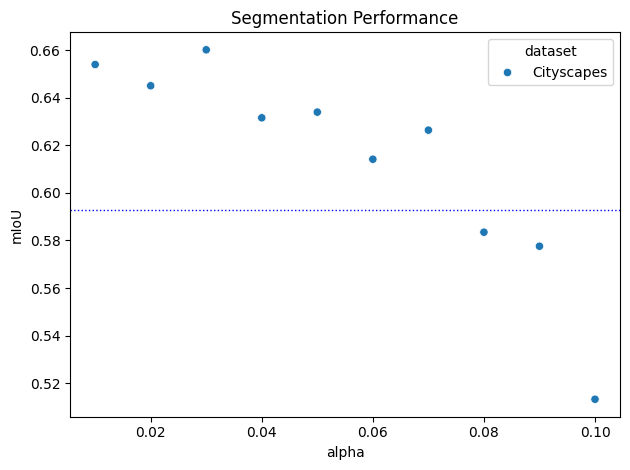

In [74]:
baseline_segmentation_metrics = baseline_metrics[baseline_metrics["dataset"] == "Cityscapes"]

method_segmentation_metrics = method_metrics[method_metrics["dataset"] == "Cityscapes"]

baseline_segmentation_metrics = baseline_segmentation_metrics.pivot(index=["run_id"], columns="metric", values=["value"])
baseline_segmentation_metrics.columns = [col[1] if col[1] else col[0] for col in baseline_segmentation_metrics.columns]

method_segmentation_metrics = method_segmentation_metrics.pivot(index=["run_id", "alpha", "dataset"], columns="metric", values=["value"]).reset_index().sort_values("alpha")
method_segmentation_metrics.columns = [col[1] if col[1] else col[0] for col in method_segmentation_metrics.columns ]

sns.scatterplot(data=method_segmentation_metrics, x="alpha", y="test_jaccard", hue="dataset")
plt.axhline(y=baseline_segmentation_metrics.iloc[0]["test_jaccard"], color='b', linestyle=':', linewidth=1)
plt.ylabel("mIoU")
plt.title("Segmentation Performance")
plt.tight_layout()
plt.savefig(f'{image_output_directory}/segmentation_performance.png', dpi=300, bbox_inches='tight')


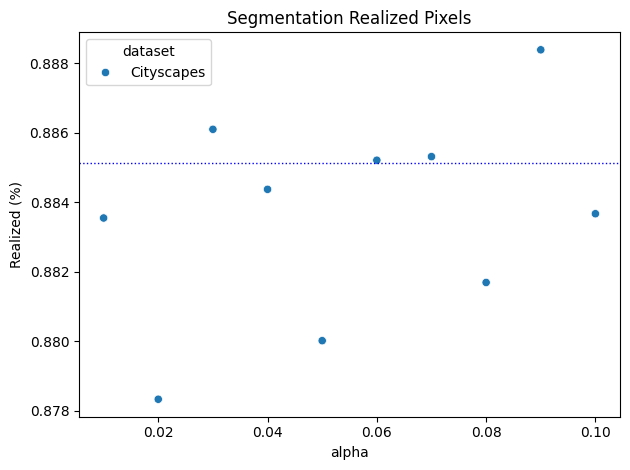

In [75]:
sns.scatterplot(data=method_segmentation_metrics, x="alpha", y="test_realized", hue="dataset")
plt.axhline(y=baseline_segmentation_metrics.iloc[0]["test_realized"], color='b', linestyle=':', linewidth=1)
plt.ylabel("Realized (%)")
plt.title("Segmentation Realized Pixels")
plt.tight_layout()
plt.savefig(f'{image_output_directory}/segmentation_realized.png', dpi=300, bbox_inches='tight')

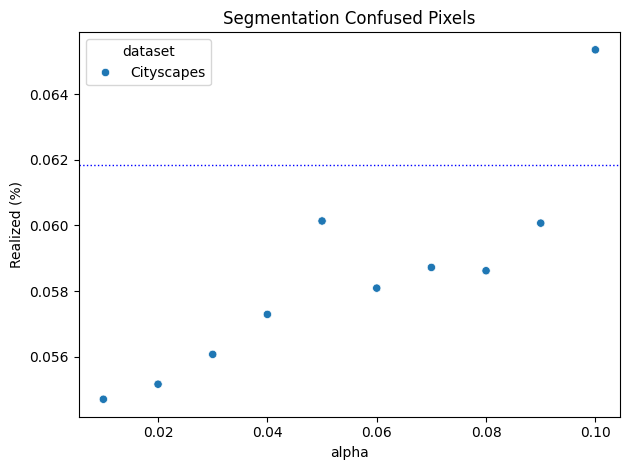

In [76]:
sns.scatterplot(data=method_segmentation_metrics, x="alpha", y="test_confused", hue="dataset")
plt.axhline(y=baseline_segmentation_metrics.iloc[0]["test_confused"], color='b', linestyle=':', linewidth=1)
plt.ylabel("Realized (%)")
plt.title("Segmentation Confused Pixels")
plt.tight_layout()
plt.savefig(f'{image_output_directory}/segmentation_confused.png', dpi=300, bbox_inches='tight')

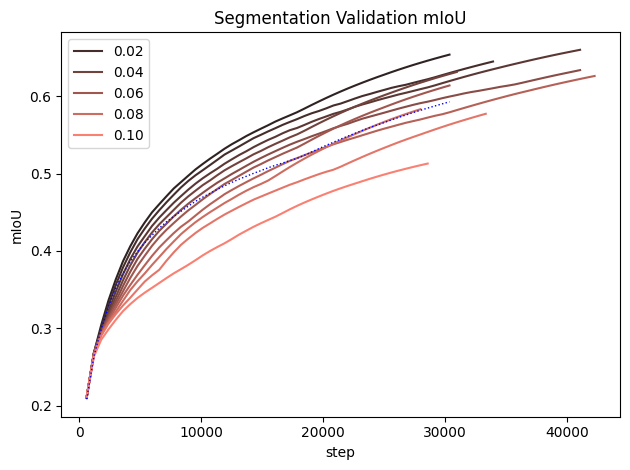

In [77]:
baseline_val_segmentation_metrics = baseline_val_metrics[baseline_val_metrics["dataset"] == "Cityscapes"]
method_val_segmentation_metrics = method_val_metrics[method_val_metrics["dataset"] == "Cityscapes"]

method_val_segmentation_metrics = method_val_segmentation_metrics.pivot(index=["run_id", "alpha", "dataset", "step"], columns="metric", values=["value"]).reset_index().sort_values("alpha")
method_val_segmentation_metrics.columns = [col[1] if col[1] else col[0] for col in method_val_segmentation_metrics.columns ]

baseline_val_segmentation_metrics = baseline_val_segmentation_metrics.pivot(index=["run_id", "dataset", "step"], columns="metric", values=["value"]).reset_index()
baseline_val_segmentation_metrics.columns = [col[1] if col[1] else col[0] for col in baseline_val_segmentation_metrics.columns ]

palette = sns.color_palette("dark:salmon", as_cmap=True)

fig, ax = plt.subplots()
sns.lineplot(data=method_val_segmentation_metrics, x="step", y="val_jaccard", hue="alpha", ax=ax, palette=palette, legend='auto')
sns.lineplot(data=baseline_val_segmentation_metrics, x="step", y="val_jaccard", color='b', linestyle=':', linewidth=1, ax=ax)
plt.ylabel("mIoU")
plt.title("Segmentation Validation mIoU")
plt.tight_layout()
plt.savefig(f'{image_output_directory}/segmentation_val_miou.png', dpi=300, bbox_inches='tight')


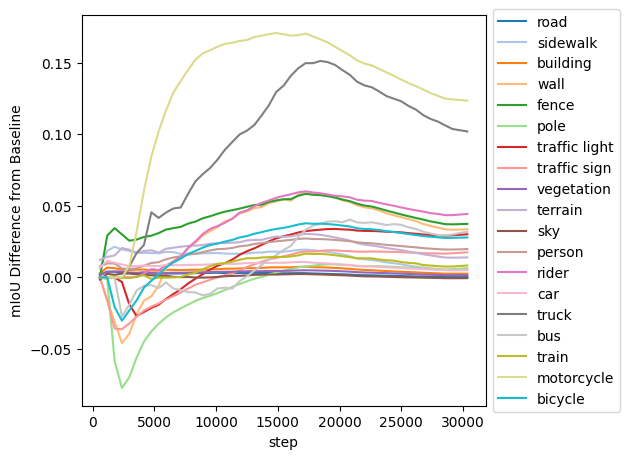

In [113]:
classes = [
    "road",
    "sidewalk",
    "building",
    "wall",
    "fence",
    "pole",
    "traffic light",
    "traffic sign",
    "vegetation",
    "terrain",
    "sky",
    "person",
    "rider",
    "car",
    "truck",
    "bus",
    "train",
    "motorcycle",
    "bicycle",
]

best_method_val_segmentation_metrics = method_val_segmentation_metrics[method_val_segmentation_metrics["alpha"] == 0.03]

joined_segmentation_metrics = pd.merge(best_method_val_segmentation_metrics, baseline_val_segmentation_metrics, on=["step", "dataset"], how="inner", suffixes=("_method", "_baseline"))

difference_metrics = pd.DataFrame()
difference_metrics["step"] = joined_segmentation_metrics["step"]

for clazz in classes:
    difference_metrics[clazz] = joined_segmentation_metrics[f"val_jaccard_{clazz}_method"] - joined_segmentation_metrics[f"val_jaccard_{clazz}_baseline"]

palette = sns.color_palette("tab20", as_cmap=True)

difference_metrics = difference_metrics.melt(id_vars=["step"], var_name="class", value_name="delta")
fig, ax = plt.subplots()
sns.lineplot(data=difference_metrics, x="step", y="delta", hue="class", ax=ax, palette=palette.colors)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylabel("mIoU Difference from Baseline")
plt.tight_layout()
plt.savefig(f'{image_output_directory}/segmentation_val_iou_difference.png', dpi=300, bbox_inches='tight')

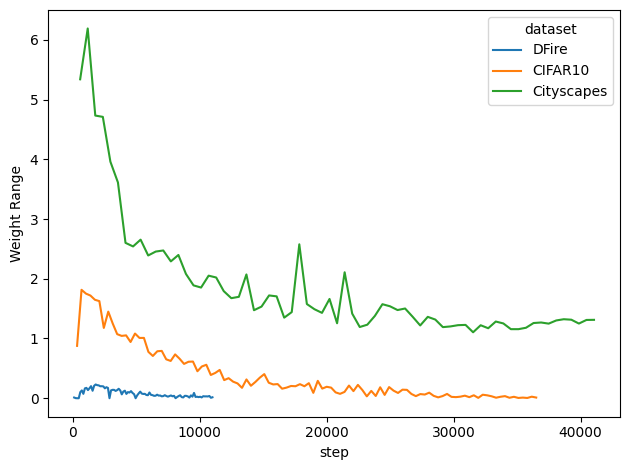

In [201]:
best_weight_metrics = weight_metrics[ (weight_metrics["purpose"] == "Method") & (( (weight_metrics["dataset"] == "DFire") & (weight_metrics["alpha"] == 0.01) ) | ( (weight_metrics["dataset"] == "Cityscapes") & (weight_metrics["alpha"] == 0.03)) | ( (weight_metrics["dataset"] == "CIFAR10") & (weight_metrics["alpha"] == 0.10)))]
best_weight_metrics = best_weight_metrics.pivot(index=["step", "dataset"], columns="metric", values=["value"]).reset_index()
best_weight_metrics.columns = [col[1] if col[1] else col[0] for col in best_weight_metrics.columns ]

sns.lineplot(best_weight_metrics, x="step", y="weight_range", hue="dataset")
plt.ylabel("Weight Range")
plt.tight_layout()
plt.savefig(f'{image_output_directory}/weight_range.png', dpi=300, bbox_inches='tight')

In [194]:
best_test_metrics = test_metrics[ (test_metrics["purpose"] == "Baseline") | (( (test_metrics["dataset"] == "DFire") & (test_metrics["alpha"] == 0.01) ) | ( (test_metrics["dataset"] == "Cityscapes") & (test_metrics["alpha"] == 0.03)) | ( (test_metrics["dataset"] == "CIFAR10") & (test_metrics["alpha"] == 0.10)))]

best_test_metrics = best_test_metrics.groupby(by=["purpose", "dataset", "metric"]).agg("max")[["value"]].reset_index()
best_test_metrics["metric"] = best_test_metrics["metric"].apply(lambda x: x.replace("test_", "").title())

allowed_metrics = [
    "Accuracy",
    "Jaccard",
    "Realized",
    "Confused",
    "Uncertain",
    "Loss",
]
best_test_metrics = best_test_metrics[(best_test_metrics["metric"].isin(allowed_metrics))].groupby(["purpose", "dataset", "metric"]).agg("max")


best_test_metrics = best_test_metrics.pivot_table(
    index=['dataset', 'metric'], 
    columns='purpose', 
    values='value'
)

best_test_metrics["Delta"] = best_test_metrics["Method"] - best_test_metrics["Baseline"]

best_test_metrics.to_latex(f"{table_output_directory}/best_test_metrics.tex", float_format="%.3f")



In [131]:
best_test_metrics = method_segmentation_metrics[method_segmentation_metrics["alpha"] == 0.03]

test_difference_metrics = []

for clazz in classes:
    method = best_test_metrics.iloc[0][f"test_jaccard_{clazz}"]
    baseline = baseline_segmentation_metrics.iloc[0][f"test_jaccard_{clazz}"]
    test_difference_metrics.append({
        "class": clazz,
        "baseline": baseline,
        "method": method,
        "difference": method - baseline
    })

test_difference_metrics = pd.DataFrame(test_difference_metrics).sort_values("difference", ascending=False)
test_difference_metrics.to_latex(f"{table_output_directory}/segmentation_miou_difference.tex", index=False, float_format="%.3f")

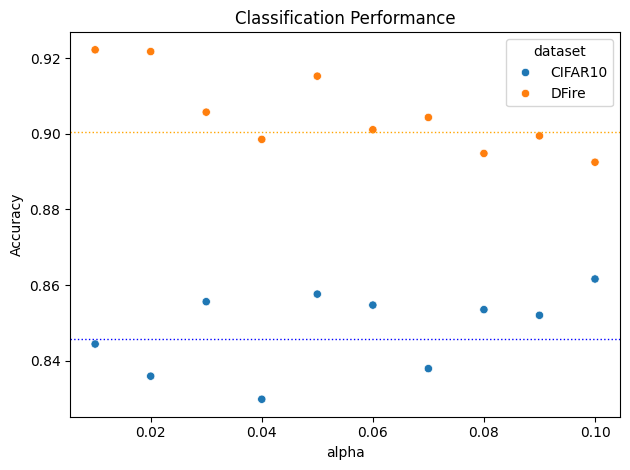

In [200]:
baseline_classification_metrics = baseline_metrics[baseline_metrics["dataset"] != "Cityscapes"]
baseline_classification_metrics = baseline_classification_metrics.pivot(index=["run_id", "dataset"], columns="metric", values=["value"]).reset_index()
baseline_classification_metrics.columns = [col[1] if col[1] else col[0] for col in baseline_classification_metrics.columns ]


method_classification_metrics = method_metrics[method_metrics["dataset"] != "Cityscapes"]
method_classification_metrics = method_classification_metrics.pivot(index=["run_id", "alpha", "dataset"], columns="metric", values=["value"]).reset_index().sort_values("alpha")
method_classification_metrics.columns = [col[1] if col[1] else col[0] for col in method_classification_metrics.columns ]

sns.scatterplot(data=method_classification_metrics, x="alpha", y="test_accuracy", hue="dataset")
plt.axhline(y=baseline_classification_metrics[baseline_classification_metrics["dataset"] == "CIFAR10"].iloc[0]["test_accuracy"], color='b', linestyle=':', linewidth=1)
plt.axhline(y=baseline_classification_metrics[baseline_classification_metrics["dataset"] == "DFire"].iloc[0]["test_accuracy"], color='orange', linestyle=':', linewidth=1)
plt.ylabel("Accuracy")
plt.title("Classification Performance")
plt.tight_layout()
plt.savefig(f'{image_output_directory}/classification_performance.png', dpi=300, bbox_inches='tight')


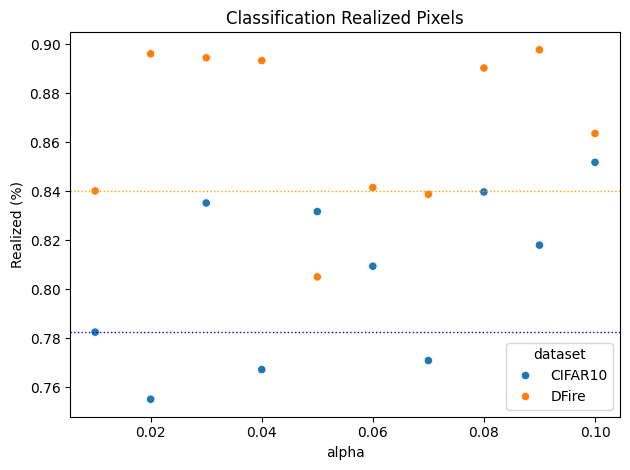

In [86]:
sns.scatterplot(data=method_classification_metrics, x="alpha", y="test_realized", hue="dataset")
plt.axhline(y=method_classification_metrics[method_classification_metrics["dataset"] == "CIFAR10"].iloc[0]["test_realized"], color='b', linestyle=':', linewidth=1)
plt.axhline(y=method_classification_metrics[method_classification_metrics["dataset"] == "DFire"].iloc[0]["test_realized"], color='orange', linestyle=':', linewidth=1)
plt.ylabel("Realized (%)")
plt.title("Classification Realized Pixels")
plt.tight_layout()
plt.savefig(f'{image_output_directory}/classification_realized.png', dpi=300, bbox_inches='tight')


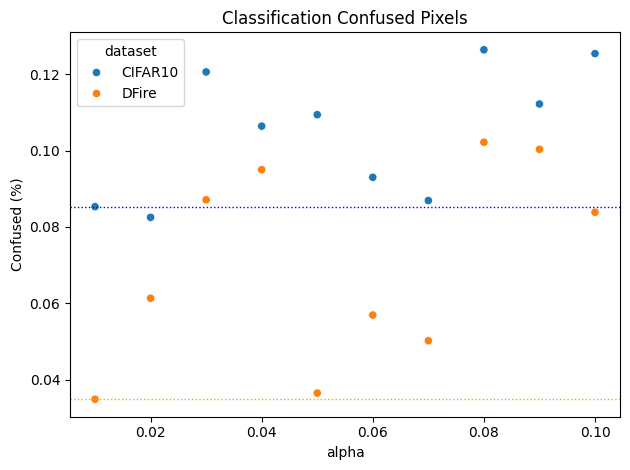

In [85]:
sns.scatterplot(data=method_classification_metrics, x="alpha", y="test_confused", hue="dataset")
plt.axhline(y=method_classification_metrics[method_classification_metrics["dataset"] == "CIFAR10"].iloc[0]["test_confused"], color='b', linestyle=':', linewidth=1)
plt.axhline(y=method_classification_metrics[method_classification_metrics["dataset"] == "DFire"].iloc[0]["test_confused"], color='orange', linestyle=':', linewidth=1)
plt.ylabel("Confused (%)")
plt.title("Classification Confused Pixels")
plt.tight_layout()
plt.savefig(f'{image_output_directory}/classification_confused.png', dpi=300, bbox_inches='tight')

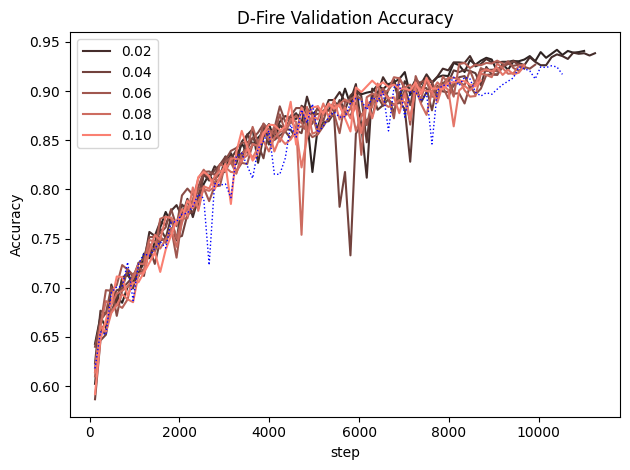

In [79]:
baseline_val_classificaion_metrics = baseline_val_metrics[baseline_val_metrics["dataset"] != "Cityscapes"]
method_val_classificaion_metrics = method_val_metrics[method_val_metrics["dataset"] != "Cityscapes"]

method_val_classificaion_metrics = method_val_classificaion_metrics.pivot(index=["run_id", "alpha", "dataset", "step"], columns="metric", values=["value"]).reset_index().sort_values("alpha")
method_val_classificaion_metrics.columns = [col[1] if col[1] else col[0] for col in method_val_classificaion_metrics.columns ]

baseline_val_classificaion_metrics = baseline_val_classificaion_metrics.pivot(index=["run_id", "dataset", "step"], columns="metric", values=["value"]).reset_index()
baseline_val_classificaion_metrics.columns = [col[1] if col[1] else col[0] for col in baseline_val_classificaion_metrics.columns ]

dfire_method_metrics = method_val_classificaion_metrics[method_val_classificaion_metrics["dataset"] == "DFire"]
dfire_baseline_metrics = baseline_val_classificaion_metrics[baseline_val_classificaion_metrics["dataset"] == "DFire"]

palette = sns.color_palette("dark:salmon", as_cmap=True)
fig, ax = plt.subplots()
sns.lineplot(data=dfire_method_metrics, x="step", y="val_accuracy", hue="alpha", ax=ax, palette=palette, legend='auto')
sns.lineplot(data=dfire_baseline_metrics, x="step", y="val_accuracy", color='b', linestyle=':', linewidth=1, ax=ax)
plt.ylabel("Accuracy")
plt.title("D-Fire Validation Accuracy")
plt.tight_layout()
plt.savefig(f'{image_output_directory}/dfire_val_accuracy.png', dpi=300, bbox_inches='tight')

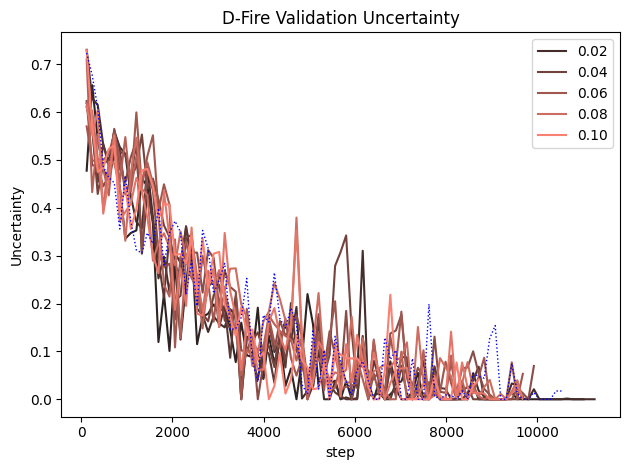

In [80]:
palette = sns.color_palette("dark:salmon", as_cmap=True)
fig, ax = plt.subplots()
sns.lineplot(data=dfire_method_metrics, x="step", y="val_uncertain", hue="alpha", ax=ax, palette=palette, legend='auto')
sns.lineplot(data=dfire_baseline_metrics, x="step", y="val_uncertain", color='b', linestyle=':', linewidth=1, ax=ax)
plt.ylabel("Uncertainty")
plt.title("D-Fire Validation Uncertainty")
plt.tight_layout()
plt.savefig(f'{image_output_directory}/dfire_val_uncertainty.png', dpi=300, bbox_inches='tight')

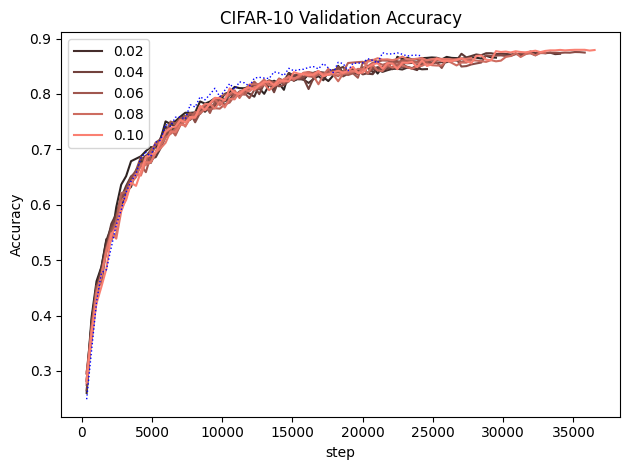

In [81]:
cifar_method_metrics = method_val_classificaion_metrics[method_val_classificaion_metrics["dataset"] == "CIFAR10"]
cifar_baseline_metrics = baseline_val_classificaion_metrics[baseline_val_classificaion_metrics["dataset"] == "CIFAR10"]

palette = sns.color_palette("dark:salmon", as_cmap=True)
fig, ax = plt.subplots()
sns.lineplot(data=cifar_method_metrics, x="step", y="val_accuracy", hue="alpha", ax=ax, palette=palette, legend='auto')
sns.lineplot(data=cifar_baseline_metrics, x="step", y="val_accuracy", color='b', linestyle=':', linewidth=1, ax=ax)
plt.ylabel("Accuracy")
plt.title("CIFAR-10 Validation Accuracy")
plt.tight_layout()
plt.savefig(f'{image_output_directory}/dfire_val_accuracy.png', dpi=300, bbox_inches='tight')

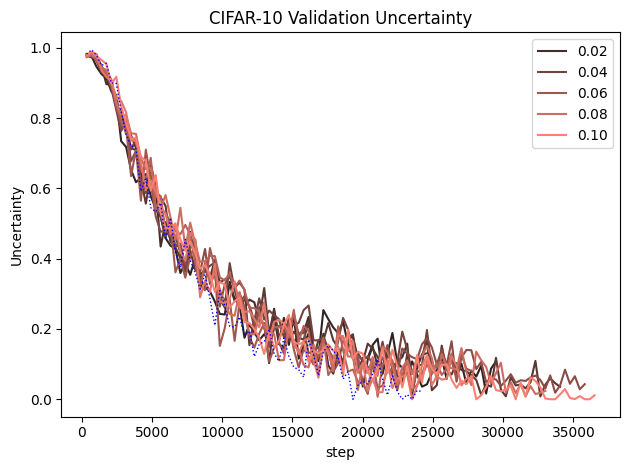

In [82]:
palette = sns.color_palette("dark:salmon", as_cmap=True)
fig, ax = plt.subplots()
sns.lineplot(data=cifar_method_metrics, x="step", y="val_uncertain", hue="alpha", ax=ax, palette=palette, legend='auto')
sns.lineplot(data=cifar_baseline_metrics, x="step", y="val_uncertain", color='b', linestyle=':', linewidth=1, ax=ax)
plt.ylabel("Uncertainty")
plt.title("CIFAR-10 Validation Uncertainty")
plt.tight_layout()
plt.savefig(f'{image_output_directory}/cifar_val_uncertainty.png', dpi=300, bbox_inches='tight')

In [ ]:
palette = sns.color_palette("dark:salmon", as_cmap=True)
fig, ax = plt.subplots()
sns.lineplot(data=dfire_method_metrics, x="step", y="val_realized", hue="alpha", ax=ax, palette=palette, legend='auto')
sns.lineplot(data=dfire_baseline_metrics, x="step", y="val_accuracy", color='b', linestyle=':', linewidth=1, ax=ax)
plt.ylabel("Accuracy")
plt.title("D-Fire Validation Accuracy")
plt.tight_layout()
plt.savefig(f'{image_output_directory}/dfire_val_accuracy.png', dpi=300, bbox_inches='tight')